## Code for simulating theta cycling of place cells in a T-maze environment

In [55]:
import numpy as np
import brainpy.math as bm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")

from sweep.network_models import PCNet, PCParams
from sweep import plotting

from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from tqdm import tqdm

bm.set_dt(1.)

#auto reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def simulate_pcnet(net: PCNet, positions, velocity_gains, theta_strength=0, theta_cycle_len=100):
    """Simulate DCNet over a trajectory of directions and velocity gains."""
    def step(i, position, velocity_gain):
        # theta oscillation phase
        t = i * bm.dt
        theta_phase = bm.mod(t, theta_cycle_len) / theta_cycle_len
        theta_phase = theta_phase * 2 * np.pi - np.pi

        # theta modulation
        theta_modulation = 1 + theta_strength * velocity_gain * bm.cos(theta_phase)

        # update network
        net.step_run(i, position, theta_modulation)

        return net.center, net.r, theta_phase, theta_modulation

    return bm.for_loop(
        step,
        (bm.arange(len(positions)), positions, velocity_gains),
        progress_bar=True
    )


### 1. first let's build a simple linear track environment using nx, and then we switch to a T-maze environment

节点数: 151, 轨道总长度: 1.5 m
总节点数: 151


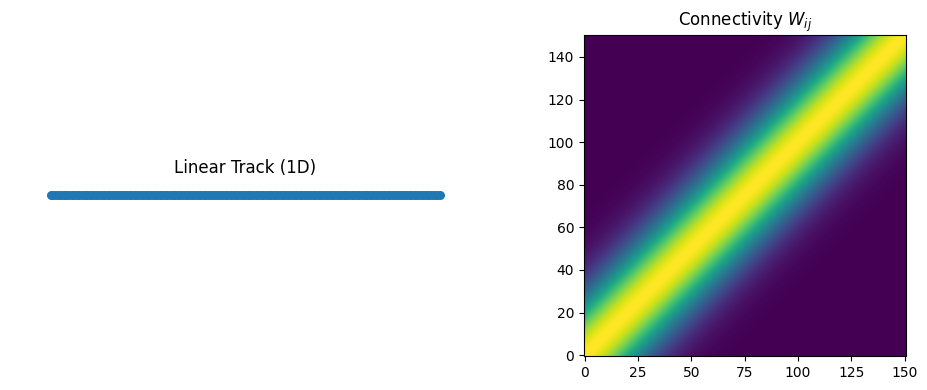

In [57]:

# ======================================================
# 1. 参数设置
# ======================================================
L_track = 1.5   # 线性跑道总长度 (m)
dx = 0.01        # 节点间距 (m)
n = int(L_track / dx) + 1   # 节点总数

print(f"节点数: {n}, 轨道总长度: {L_track} m")

# ======================================================
# 2. 构建线性轨道图
# ======================================================
graph = nx.Graph()
graph.graph['dx'] = dx
for i in range(n - 1):
    graph.add_edge(i, i + 1, weight=dx)

nodes = list(graph.nodes)
N = len(nodes)
print(f"总节点数: {N}")

#3, build the network

params = PCParams(adaptation_strength=10, a=0.2)
pc_net = PCNet(graph, params=params)   

# ======================================================
# 5. 可视化
# ======================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (a) 线性轨道布局
pos = {i: (i * dx, 0) for i in range(n)}
nx.draw(graph, pos, node_size=30, ax=ax[0])
ax[0].set_aspect('equal', 'box')
ax[0].set_title("Linear Track (1D)")

# (b) 可视化连接矩阵
synaptic_connection  = pc_net.conn_mat
im = ax[1].imshow(synaptic_connection, cmap='viridis', origin='lower')
ax[1].set_title("Connectivity $W_{ij}$")
plt.tight_layout()


/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/utils.py:891: UserWarning: Found 1 unexpected params key(s) while initializing Agent object: 'rotation_velocity_std'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call Agent.get_all_default_params().
  warnings.warn(
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/Agent.py:145: UserWarning: Warning: You have solid 1D boundary conditions and non-zero speed mean.
  warnings.warn(
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 17070.97it/s]


5000 5000


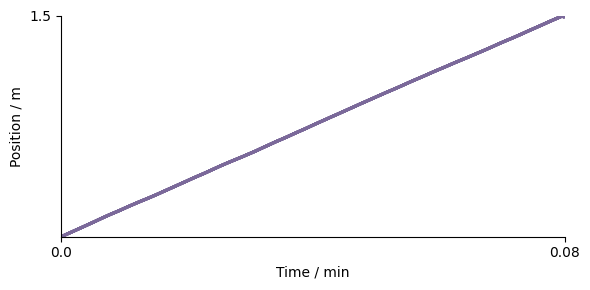

In [61]:
np.random.seed(10) #for reproducibility
#We will create a circular environment with a circular hole in the center, so that head direction keeps changing. Cleaver and simple, right!
Env = Environment(params={"dimensionality": "1D", "scale": L_track})

#dt is 1 ms
Ag = Agent(Env,params={'dt':0.001, 'speed_mean':0.3, 'speed_std':0.01, 'speed_coherence_time':0.08,
                      'rotation_velocity_std':180*np.pi/180, 'rotational_velocity_coherence_time':0.01})

simulate_time = 5 #seconds

Ag.pos = np.array([0.0]) #set initial position
for i in tqdm(range(int( simulate_time / Ag.dt))): 
    Ag.update()
    


#plot 
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi=100)
Ag.plot_trajectory(fig=fig, ax=ax, framerate=1000)
plt.tight_layout()

print(len(Ag.history["pos"]), len(Ag.history["vel"]))


In [62]:
positions = np.array(Ag.history["pos"]).squeeze()
#embedding positions into index 
animal_pos_node_index = np.clip(
    np.round(positions / dx).astype(int),
    0,
    n - 1
)

velocity = np.array(Ag.history["vel"]).squeeze()

# velocity_gains = np.abs(velocity)/np.max(np.abs(velocity))

velocity_gains = np.abs(velocity)/np.percentile(np.abs(velocity), 99)

# build the network
params = PCParams(adaptation_strength=10, a=0.1)
pc_net = PCNet(graph, params=params)   

# simulate the DC network
internal_position, net_activity, theta_phase, theta_modulation = simulate_pcnet(
    pc_net, animal_pos_node_index, velocity_gains, theta_strength=10, theta_cycle_len=100
)

internal_direction = np.array(internal_position)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_2301057/1182174055.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


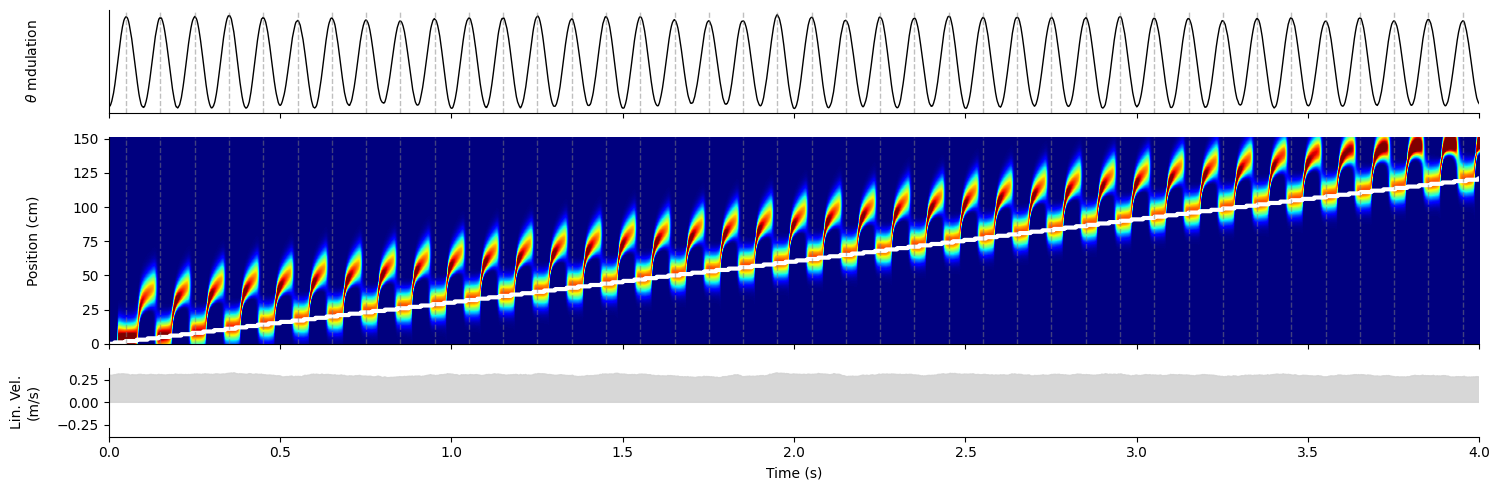

In [67]:
time_steps = np.array(Ag.history["t"])

fig, axes = plt.subplots(
    3,
    1,
    figsize=(15, 5),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=100,
)

ax = axes[0]
#set theta_modulation outliear as median
theta_modulation[theta_modulation > np.median(theta_modulation) + 10 * np.std(theta_modulation)] = np.median(theta_modulation)
theta_modulation[theta_modulation < np.median(theta_modulation) - 10 * np.std(theta_modulation)] = np.median(theta_modulation)
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=5e-2)

ax = axes[1]
ax = plotting.plot_population_activity_linear(ax, time_steps, theta_phase, net_activity, animal_pos_node_index, add_lines=True, atol=5e-2)

ax = axes[2]
ax = plotting.plot_linear_velocity(ax, time_steps, velocity)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.05, 0.5)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.set_xlim(0,4)

plt.tight_layout()


### 2. Define T-maze as graph

中央臂节点数: 15, 左臂节点数: 10, 右臂节点数: 10
总节点数: 36


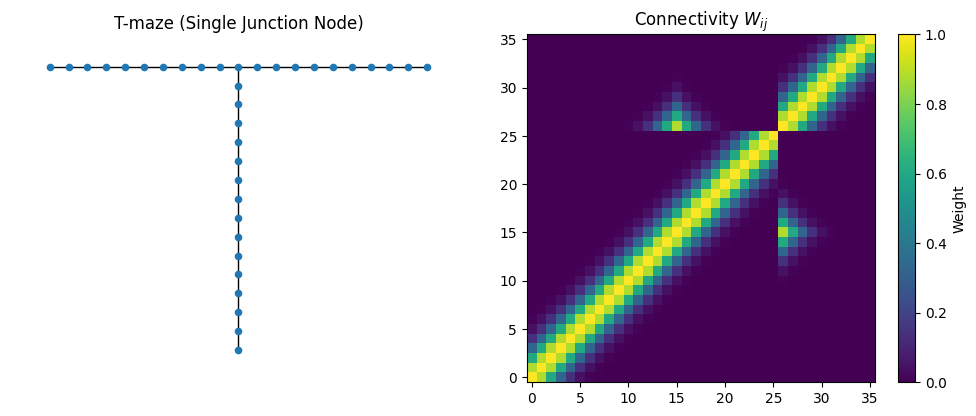

C 起点 → J: 1.50 m
C 起点 → L 末端: 2.50 m
L 末端 → R 末端: 2.00 m


In [64]:

# ======================================================
# 1. 参数设置
# ======================================================
L_CJ = 1.5   # 中央臂长度 (m)
L_JL = 1.0   # 左臂长度 (m)
L_JR = 1.0   # 右臂长度 (m)
dx = 0.1     # 节点间距 (m)

nC = int(L_CJ / dx)
nL = int(L_JL / dx)
nR = int(L_JR / dx)

print(f"中央臂节点数: {nC}, 左臂节点数: {nL}, 右臂节点数: {nR}")

# ======================================================
# 2. 构建图：每 1 cm 一个节点
# ======================================================
G = nx.Graph()

# --- 中央臂: C0 → C(nC-1) ---
for i in range(nC - 1):
    G.add_edge(('C', i), ('C', i + 1), weight=dx)
# 最远端连接到交叉点 J
G.add_edge(('C', nC - 1), 'J', weight=dx)

# --- 左臂: J → L(nL-1) ---
for i in range(nL - 1):
    G.add_edge(('L', i), ('L', i + 1), weight=dx)
# 起点连接交叉点 J
G.add_edge('J', ('L', 0), weight=dx)

# --- 右臂: J → R(nR-1) ---
for i in range(nR - 1):
    G.add_edge(('R', i), ('R', i + 1), weight=dx)
# 起点连接交叉点 J
G.add_edge('J', ('R', 0), weight=dx)

nodes = list(G.nodes)
N = len(nodes)
print(f"总节点数: {N}")

# ======================================================
# 3. 计算 geodesic 距离矩阵
# ======================================================
geo = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))
D = np.zeros((N, N))
for i, ni in enumerate(nodes):
    for j, nj in enumerate(nodes):
        D[i, j] = geo[ni][nj]

# ======================================================
# 4. 计算基于 geodesic 距离的连接矩阵
# ======================================================
sigma = 0.2  # 高斯衰减常数 (m)
W = np.exp(-D**2 / (2 * sigma**2))

# ======================================================
# 5. 可视化
# ======================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (a) T 迷宫布局 (2D 坐标)
pos = {}
for i in range(nC):
    pos[('C', i)] = (0, i * dx)
pos['J'] = (0, L_CJ)
for i in range(nL):
    pos[('L', i)] = (- (i + 1) * dx, L_CJ)
for i in range(nR):
    pos[('R', i)] = ((i + 1) * dx, L_CJ)

nx.draw(G, pos, node_size=20, ax=ax[0])
ax[0].set_aspect('equal', 'box')
ax[0].set_title("T-maze (Single Junction Node)")

# (b) 可视化连接矩阵
im = ax[1].imshow(W, cmap='viridis', origin='lower')
ax[1].set_title("Connectivity $W_{ij}$")
fig.colorbar(im, ax=ax[1], label="Weight")
plt.tight_layout()
plt.show()

# ======================================================
# 6. 验证几何正确性
# ======================================================
geo_test = dict(nx.single_source_dijkstra_path_length(G, ('C', 0), weight='weight'))
print(f"C 起点 → J: {geo_test['J']:.2f} m")
print(f"C 起点 → L 末端: {geo_test[('L', nL - 1)]:.2f} m")
print(f"L 末端 → R 末端: {geo[('L', nL - 1)][('R', nR - 1)]:.2f} m")


In [68]:
# ======================================================
# Geometric coordinates for visualisation / spatial embedding
# ======================================================
pos = {}

for n in nodes:
    if isinstance(n, tuple):
        seg, i = n
        if seg == 'C':  # central arm (vertical)
            pos[n] = (0.0, i * dx)
        elif seg == 'L':  # left arm (horizontal, leftwards)
            pos[n] = (-(i + 1) * dx, L_CJ)
        elif seg == 'R':  # right arm (horizontal, rightwards)
            pos[n] = ((i + 1) * dx, L_CJ)
    elif n == 'J':  # single junction node
        pos[n] = (0.0, L_CJ)

# Convert all node positions into an array following the same order as 'nodes'
x_bins = np.array([pos[n] for n in nodes])  # shape (N, 2)

print("x_bins shape:", x_bins.shape)
print(x_bins)

x_bins shape: (36, 2)
[[ 0.   0. ]
 [ 0.   0.1]
 [ 0.   0.2]
 [ 0.   0.3]
 [ 0.   0.4]
 [ 0.   0.5]
 [ 0.   0.6]
 [ 0.   0.7]
 [ 0.   0.8]
 [ 0.   0.9]
 [ 0.   1. ]
 [ 0.   1.1]
 [ 0.   1.2]
 [ 0.   1.3]
 [ 0.   1.4]
 [ 0.   1.5]
 [-0.1  1.5]
 [-0.2  1.5]
 [-0.3  1.5]
 [-0.4  1.5]
 [-0.5  1.5]
 [-0.6  1.5]
 [-0.7  1.5]
 [-0.8  1.5]
 [-0.9  1.5]
 [-1.   1.5]
 [ 0.1  1.5]
 [ 0.2  1.5]
 [ 0.3  1.5]
 [ 0.4  1.5]
 [ 0.5  1.5]
 [ 0.6  1.5]
 [ 0.7  1.5]
 [ 0.8  1.5]
 [ 0.9  1.5]
 [ 1.   1.5]]
